# Chapter 12

## Setup and imports

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats
import matplotlib.pyplot as plt

In [4]:
nhefs_all = pd.read_excel('NHEFS.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


Just a look at a couple basic details of the dataset

In [5]:
nhefs_all.shape

(1629, 64)

In [6]:
nhefs_all.columns

Index(['seqn', 'qsmk', 'death', 'yrdth', 'modth', 'dadth', 'sbp', 'dbp', 'sex',
       'age', 'race', 'income', 'marital', 'school', 'education', 'ht', 'wt71',
       'wt82', 'wt82_71', 'birthplace', 'smokeintensity', 'smkintensity82_71',
       'smokeyrs', 'asthma', 'bronch', 'tb', 'hf', 'hbp', 'pepticulcer',
       'colitis', 'hepatitis', 'chroniccough', 'hayfever', 'diabetes', 'polio',
       'tumor', 'nervousbreak', 'alcoholpy', 'alcoholfreq', 'alcoholtype',
       'alcoholhowmuch', 'pica', 'headache', 'otherpain', 'weakheart',
       'allergies', 'nerves', 'lackpep', 'hbpmed', 'boweltrouble', 'wtloss',
       'infection', 'active', 'exercise', 'birthcontrol', 'pregnancies',
       'cholesterol', 'hightax82', 'price71', 'price82', 'tax71', 'tax82',
       'price71_82', 'tax71_82'],
      dtype='object')

## Section 12.1

### Program 12.1

"We restricted the analysis to NHEFS individuals with known sex, age, race, ..."

In [7]:
restriction_cols = [
    'sex', 'age', 'race', 'wt82', 'ht', 'school', 'alcoholpy', 'smokeintensity'
]
missing = nhefs_all[restriction_cols].isnull().any(axis=1)
nhefs = nhefs_all.loc[~missing]

In [8]:
nhefs.shape

(1566, 64)

We're going to add some columns to help calculate Table 12.1, and a `constant` column, which will be useful for modeling

In [9]:
nhefs['constant'] = 1
nhefs['university'] = (nhefs.education == 5).astype('int')
nhefs['inactive'] = (nhefs.active == 2).astype('int')
nhefs['no_exercise'] = (nhefs.exercise == 2).astype('int')

Average weight gains in quitters and non-quitters:

In [10]:
ave_gain_quit = nhefs[nhefs.qsmk == 1].wt82_71.mean()
ave_gain_noquit = nhefs[nhefs.qsmk == 0].wt82_71.mean()

print("Average weight gain")
print("      quitters: {:>0.1f} kg".format(ave_gain_quit))
print("  non-quitters: {:>0.1f} kg".format(ave_gain_noquit))

Average weight gain
      quitters: 4.5 kg
  non-quitters: 2.0 kg


Create a simple linear model to get a confidence interval on weight difference.

In [11]:
ols = sm.OLS(nhefs.wt82_71, nhefs[['constant', 'qsmk']])
res = ols.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
constant,1.9845,0.229,8.672,0.000,1.536,2.433
qsmk,2.5406,0.451,5.632,0.000,1.656,3.425


In [12]:
est = res.params.qsmk
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]['qsmk'], conf_ints[1]['qsmk']

print('            estimate   95% C.I.')
print('difference   {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

            estimate   95% C.I.
difference     2.54   (1.7, 3.4)


Create Table 12.1 in the margin of pg 11.

In [13]:
summaries = OrderedDict((
    ('age', 'mean'),
    ('sex', lambda x: (100 * (x == 0)).mean()),
    ('race', lambda x: (100 * (x == 0)).mean()),
    ('university', lambda x: 100 * x.mean()),
    ('wt71', 'mean'),
    ('smokeintensity', 'mean'),
    ('smokeyrs', 'mean'),
    ('no_exercise', lambda x: 100 * x.mean()),
    ('inactive', lambda x: 100 * x.mean())
))

table = nhefs.groupby('qsmk').agg(summaries)
table.sort_index(ascending=False, inplace=True)
table = table.T

table.index = [
    'Age, years',
    'Men, %',
    'White, %',
    'University education, %',
    'Weight, kg',
    'Cigarettes/day',
    'Years smoking',
    'Little or no exercise, %',
    'Inactive daily life, %'
]

table.style.format("{:>0.1f}")

qsmk,1,0
"Age, years",46.2,42.8
"Men, %",54.6,46.6
"White, %",91.1,85.4
"University education, %",15.4,9.9
"Weight, kg",72.4,70.3
Cigarettes/day,18.6,21.2
Years smoking,26.0,24.1
"Little or no exercise, %",40.7,37.9
"Inactive daily life, %",11.2,8.9


## Section 12.2

### Program 12.2

We're going to be modeling with squared terms and some categorical features. Here we'll explicitly add squared features and dummy features to the data. In later chapters we'll use Statsmodels' formula syntax.

Squared features:

In [14]:
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    nhefs['{}^2'.format(col)] = nhefs[col] * nhefs[col]

Dummy features:

In [15]:
edu_dummies = pd.get_dummies(nhefs.education, prefix='edu')
exercise_dummies = pd.get_dummies(nhefs.exercise, prefix='exercise')
active_dummies = pd.get_dummies(nhefs.active, prefix='active')

nhefs = pd.concat(
    [nhefs, edu_dummies, exercise_dummies, active_dummies],
    axis=1
)

We're going to be creating a lot of IP weights from logistic regressions so a function will help reduce the work. The following function creates the denominators of the IP weights.

In [16]:
def logit_ip_f(y, X):
    """
    Create the f(y|X) part of IP weights
    from logistic regression
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    Numpy array of IP weights
    
    """
    model = sm.Logit(y, X)
    res = model.fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] = res.predict(X.loc[y == 1])
    weights[y == 0] = (1 - res.predict(X.loc[y == 0]))
    return weights

In [17]:
X_ip = nhefs[[
    'constant',
    'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2'
]]

denoms = logit_ip_f(nhefs.qsmk, X_ip)
weights = 1 / denoms

Optimization terminated successfully.
         Current function value: 0.535408
         Iterations 6


In [18]:
print('IP weights')
print('   min: {:>5.2f}   expected:  1.05'.format(weights.min()))
print('   max: {:>5.2f}   expected: 16.70'.format(weights.max()))
print('  mean: {:>5.2f}   expected:  2.00'.format(weights.mean()))

IP weights
   min:  1.05   expected:  1.05
   max: 16.70   expected: 16.70
  mean:  2.00   expected:  2.00


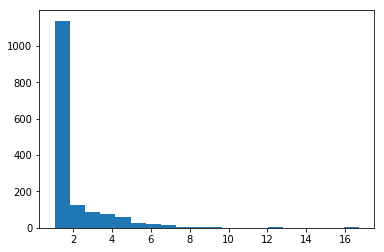

In [19]:
plt.hist(weights, bins=20);

Now, the main model

In [20]:
y = nhefs.wt82_71
X = nhefs[['constant', 'qsmk']]

Weighted least squares gives the right coefficients, but the standard error is off.

In [21]:
wls = sm.WLS(y, X, weights=weights) 
res = wls.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
constant,1.7800,0.288,6.175,0.000,1.215,2.345
qsmk,3.4405,0.408,8.434,0.000,2.640,4.241


GEE gives the right coefficients and better standard errors

In [22]:
gee = sm.GEE(
    nhefs.wt82_71,
    nhefs[['constant', 'qsmk']],
    groups=nhefs.seqn,
    weights=weights
)
res = gee.fit()
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
constant,1.7800,0.225,7.920,0.000,1.340,2.220
qsmk,3.4405,0.525,6.547,0.000,2.411,4.470


In [23]:
est = res.params.qsmk
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]['qsmk'], conf_ints[1]['qsmk']

print('           estimate   95% C.I.')
print('theta_1     {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

           estimate   95% C.I.
theta_1       3.44   (2.4, 4.5)


Here's a simple check that there is no association between `sex` and `qsmk`.

In [24]:
pd.crosstab(nhefs.sex, nhefs.qsmk, weights, aggfunc='sum')

qsmk,0,1
sex,,
0,763.607760,763.623497
1,801.748892,797.200691


(This matches the R output, but the Stata output is different.)

In [25]:
subset_indices = (nhefs.race == 0) & (nhefs.sex == 1)
subset = nhefs.loc[subset_indices]

Now a "check" for positivity

In [26]:
crosstab = pd.crosstab(subset.age, subset.qsmk).sort_index()

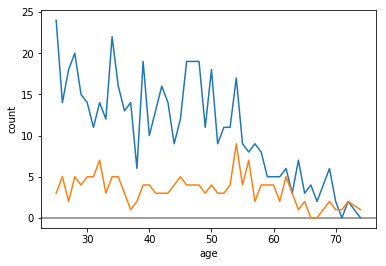

In [27]:
fig, ax = plt.subplots()

ax.axhline(0, c='gray')
ax.plot(crosstab.index, crosstab[0], label='non-quitters')
ax.plot(crosstab.index, crosstab[1], label='quitters')
ax.set_xlabel('age')
ax.set_ylabel('count');

We see that there are actually a few ages with zero counts

In [28]:
crosstab.iloc[-10:]

qsmk,0,1
age,,
63,3,3
64,7,1
65,3,2
66,4,0
67,2,0
69,6,2
70,2,1
71,0,1
72,2,2


## Section 12.3

"The effect estimate obtained in the pseudo-population created by weights $0.5 \, / \, f(A|L)$
is equal to that obtained in the pseudo-population created by weights $1 \, / \, f(A|L)$."

In [29]:
gee = sm.GEE(
    nhefs.wt82_71,
    nhefs[['constant', 'qsmk']],
    groups=nhefs.seqn,
    weights=(0.5 * weights)
)
res = gee.fit()
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
constant,1.7800,0.225,7.920,0.000,1.340,2.220
qsmk,3.4405,0.525,6.547,0.000,2.411,4.470


"Second, we need to estimate Pr[A=1] for the numerator of the weights. We can obtain a nonparametric estimate by the ratio 403/1566 or, equivalently, by fitting a saturated logistic model for Pr[A=1] with an intercept and no covariates."

In [30]:
qsmk = (nhefs.qsmk == 1)

In [31]:
# option 1
qsmk_mean = qsmk.mean()
qsmk_mean

0.25734355044699875

In [32]:
# option 2
lgt = sm.Logit(qsmk, nhefs.constant)
res = lgt.fit()
res.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.570260
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
constant,-1.0598,0.058,-18.335,0.000,-1.173,-0.947


In [33]:
lgt_pred = res.predict()

Check for equivalence

In [34]:
equivalent = np.all(np.isclose(lgt_pred, qsmk_mean))
print('equivalent: {}'.format(equivalent))

equivalent: True


### Program 12.3

Create stabilized IP weights. Shortcut: modify the IP weights already calculated.

In [35]:
s_weights = np.zeros(nhefs.shape[0])
s_weights[qsmk] = qsmk.mean() * weights[qsmk]    # qsmk was defined a few cells ago
s_weights[~qsmk] = (1 - qsmk).mean() * weights[~qsmk]

In [36]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    s_weights.min(),
    s_weights.mean(),
    s_weights.max()
))

Stabilized weights
 min   mean    max
------------------
0.33   1.00   4.30


Refit the model from the last section, using the new weights

In [37]:
gee = sm.GEE(
    nhefs.wt82_71,
    nhefs[['constant', 'qsmk']],
    groups=nhefs.seqn,
    weights=s_weights
)
res = gee.fit()
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
constant,1.7800,0.225,7.920,0.000,1.340,2.220
qsmk,3.4405,0.525,6.547,0.000,2.411,4.470


In [38]:
est = res.params.qsmk
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]['qsmk'], conf_ints[1]['qsmk']

print('           estimate   95% C.I.')
print('theta_1     {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

           estimate   95% C.I.
theta_1       3.44   (2.4, 4.5)


The estimate is the same as in the previous section

We can check again for no association between sex and qsmk in the the pseudo-population

In [39]:
pd.crosstab(nhefs.sex, nhefs.qsmk, s_weights, aggfunc='sum')

qsmk,0,1
sex,,
0,567.098228,196.513582
1,595.423986,205.154456


## Section 12.4

### Program 12.4

Subset the data to subjects that smoked 25 or fewer cigarettes per day at baseline. In this case, we can either obtain the subset from the original dataset, or we can obtain it from the reduced dataset that we've been using. I'll get it from the reduced subset, since it already contains dummy features we'll need.

In [40]:
# original dataset

intensity25 = nhefs_all.loc[
    (nhefs_all.smokeintensity <= 25) & ~nhefs_all.wt82.isnull()
]
intensity25.shape

(1162, 64)

In [41]:
# reduced dataset

intensity25 = nhefs.loc[nhefs.smokeintensity <= 25]
intensity25.shape

(1162, 83)

Create the stabilized IP weights $SW^A = f(A) \, / \, f(A|L)$

"we assumed that the density f(A|L) was normal (Gaussian) with mean $\mu = E[A|L]$ and variance $\sigma^2$.  We then used a linear regression model to estimate the mean $E[A|L]$ and variance of residuals $\sigma^2$ for all combinations of values of L."


In [42]:
A = intensity25.smkintensity82_71
X = intensity25[[
    'constant', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2'
]]

In [43]:
ols = sm.OLS(A, X)
res = ols.fit()

In [44]:
A_pred = res.predict(X)   # i.e., E[A|L]

The denominator is the distribution, $N(\mu, \sigma)$, evaluated at each point of $y = A$.

In [45]:
fAL = scipy.stats.norm.pdf(
    A,                        # A
    A_pred,                   # mu = E[A|L]
    np.sqrt(res.mse_resid)    # sigma
)

"We also assumed that the density f(A) in the numerator was normal."

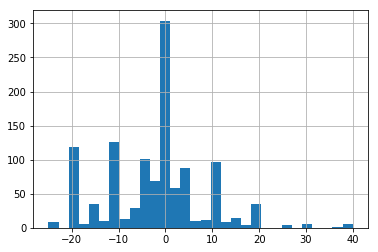

In [46]:
A.hist(bins=30);

In [47]:
A.mean(), A.std()

(-2.057659208261618, 10.467830908151853)

In [48]:
fA = scipy.stats.norm.pdf(A, A.mean(), A.std())

Then the stabilized IP weights are

In [49]:
sw = fA / fAL

In [50]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    sw.min(),
    sw.mean(),
    sw.max()
))

Stabilized weights
 min   mean    max
------------------
0.19   1.00   5.10


Now fit the marginal structural model

In [51]:
y = intensity25.wt82_71
X = pd.DataFrame(OrderedDict((
    ('constant', np.ones(y.shape[0])),
    ('A', A),
    ('A^2', A**2)
)))

model = sm.GEE(
    y,
    X,
    groups=intensity25.seqn,
    weights=sw
)
res = model.fit()

In [52]:
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
constant,2.0045,0.295,6.792,0.000,1.426,2.583
A,-0.1090,0.032,-3.456,0.001,-0.171,-0.047
A^2,0.0027,0.002,1.115,0.265,-0.002,0.007


### Program 12.5

"if interested in the causal effect of quitting smoking A (1: yes, 0: no) on the risk of death D (1: yes, 0: no) by 1992, one could consider a _marginal structural logistic model_"

In [53]:
model = sm.GEE(
    nhefs.death,
    nhefs[['constant', 'qsmk']],
    groups=nhefs.seqn,
    weights=s_weights,
    family=sm.families.Binomial()
)
res = model.fit()
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
constant,-1.4905,0.079,-18.881,0.000,-1.645,-1.336
qsmk,0.0301,0.157,0.191,0.848,-0.278,0.338


Odd ratio is $\exp(\hat{\theta}_1)$

In [54]:
est = np.exp(res.params.qsmk)
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo = np.exp(conf_ints[0]['qsmk'])
hi = np.exp(conf_ints[1]['qsmk'])

print('           estimate   95% C.I.')
print('odds ratio  {:>6.2f}   ({:>0.1f}, {:>0.1f})'.format(est, lo, hi))

           estimate   95% C.I.
odds ratio    1.03   (0.8, 1.4)


## Section 12.5

### Program 12.6

Create the numerator of the IP weights. Reuse the basic `weights` for the denominator.

In [55]:
numer = logit_ip_f(nhefs.qsmk, nhefs[['constant', 'sex']])

Optimization terminated successfully.
         Current function value: 0.567819
         Iterations 5


In [56]:
sw_AV = numer * weights

In [57]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    sw_AV.min(),
    sw_AV.mean(),
    sw_AV.max()
))

Stabilized weights
 min   mean    max
------------------
0.29   1.00   3.80


In [58]:
nhefs.shape

(1566, 83)

In [59]:
nhefs['qsmk_and_female'] = nhefs.qsmk * nhefs.sex

model = sm.WLS(
    nhefs.wt82_71,
    nhefs[['constant', 'qsmk', 'sex', 'qsmk_and_female']],
    weights=sw_AV
)
res = model.fit(cov_type='cluster', cov_kwds={'groups': nhefs.seqn})
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
constant,1.7844,0.310,5.752,0.000,1.176,2.393
qsmk,3.5220,0.658,5.353,0.000,2.232,4.811
sex,-0.0087,0.449,-0.019,0.985,-0.890,0.872
qsmk_and_female,-0.1595,1.047,-0.152,0.879,-2.212,1.893


This matches the Stata regression. The R regression is a little different.

## Section 12.6

### Program 12.7

We're going back to the original dataset

In [60]:
nhefs_all.shape

(1629, 64)

We'll add features that were added to the reduced dataset that we've been using

Add constant feature

In [61]:
nhefs_all['constant'] = 1

Add dummy features

In [62]:
edu_dummies = pd.get_dummies(nhefs_all.education, prefix='edu')
exercise_dummies = pd.get_dummies(nhefs_all.exercise, prefix='exercise')
active_dummies = pd.get_dummies(nhefs_all.active, prefix='active')

nhefs_all = pd.concat(
    [nhefs_all, edu_dummies, exercise_dummies, active_dummies],
    axis=1
)

Add squared features

In [63]:
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    nhefs_all['{}^2'.format(col)] = nhefs_all[col] * nhefs_all[col]

We'll also add a feature to track censored individuals

In [64]:
nhefs_all['censored'] = nhefs_all.wt82.isnull().astype('int')

Create the IP weights for treatment

In [65]:
X_ip = nhefs_all[[
    'constant', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2'
]]

In [66]:
ip_denom = logit_ip_f(nhefs_all.qsmk, X_ip)

Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6


In [67]:
ip_numer = logit_ip_f(nhefs_all.qsmk, nhefs_all.constant)

Optimization terminated successfully.
         Current function value: 0.575901
         Iterations 5


In [68]:
sw_A = ip_numer / ip_denom

In [69]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    sw_A.min(),
    sw_A.mean(),
    sw_A.max()
))

Stabilized weights
 min   mean    max
------------------
0.33   1.00   4.21


Now the IP weights for censoring

In [70]:
# same as previous, but with 'qsmk' added

X_ip = nhefs_all[[
    'constant', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2',
    'age', 'age^2', 'wt71', 'wt71^2',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2',
    'qsmk'
]]

In [71]:
ip_denom = logit_ip_f(nhefs_all.censored, X_ip)

Optimization terminated successfully.
         Current function value: 0.142836
         Iterations 8


In [72]:
ip_numer = logit_ip_f(
    nhefs_all.censored,
    nhefs_all[['constant', 'qsmk']]
)

Optimization terminated successfully.
         Current function value: 0.161989
         Iterations 7


In [73]:
sw_C = ip_numer / ip_denom
sw_C[nhefs_all.censored == 1] = 1

In [74]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    sw_C.min(),
    sw_C.mean(),
    sw_C.max()
))

Stabilized weights
 min   mean    max
------------------
0.94   1.00   1.72


Now create the combined IP weights

In [75]:
sw_AC = sw_A * sw_C

In [76]:
print('Stabilized weights')
print(' min   mean    max')
print('------------------')
print('{:>04.2f}   {:>04.2f}   {:>04.2f}'.format(
    sw_AC.min(),
    sw_AC.mean(),
    sw_AC.max()
))

Stabilized weights
 min   mean    max
------------------
0.35   1.00   4.09


Now model weight gain using the combined IP weights

In [77]:
wls = sm.WLS(
    nhefs.wt82_71,
    nhefs[['constant', 'qsmk']],
    weights=sw_AC[nhefs_all.censored == 0]
) 
res = wls.fit(cov_type='cluster', cov_kwds={'groups': nhefs.seqn})

In [78]:
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
constant,1.6620,0.233,7.136,0.000,1.206,2.118
qsmk,3.4965,0.526,6.648,0.000,2.466,4.527
